In [1]:
import jax
import numpyro
import numpy as np
import matplotlib.pyplot as plt
import numpyro_ext
import scipy
import jax.numpy as jnp
import pandas as pd 
from jaxoplanet.orbits.keplerian import Central
from jaxoplanet.starry.surface import Surface
from jaxoplanet.starry.orbit import SurfaceSystem

from collections.abc import Callable
from functools import partial
from jaxoplanet.starry.orbit import SurfaceSystem
from jaxoplanet.orbits.keplerian import Central, Body
from jaxoplanet.types import Array, Scalar
from jaxoplanet.core.limb_dark import light_curve as _limb_dark_light_curve
from jaxoplanet.starry.core.basis import A1, A2_inv, U
from jaxoplanet.starry.core.polynomials import Pijk
from jaxoplanet.starry.core.rotation import left_project
from jaxoplanet.starry.core.solution import rT, solution_vector
from jaxoplanet.starry.surface import Surface

# For multi-core parallelism (useful when running multiple MCMC chains in parallel)
numpyro.set_host_device_count(2)

# For CPU (use "gpu" for GPU)
numpyro.set_platform("cpu")

# For 64-bit precision since JAX defaults to 32-bit
jax.config.update("jax_enable_x64", True)

h = 6.62607015e-34  # Planck constant [J*s]
c = 2.99792458e8    # speed of light [m/s]
kB = 1.380649e-23   # Boltzmann constant [J/K]

In [2]:
def planck(lamb_m, T):
    """Planck function B_lambda in SI units."""
    a = 2*h*c**2 / (lamb_m**5)
    b = h*c / (lamb_m*kB*T)
    return a / (jnp.exp(b) - 1)

def surface_light_curve(
    surface: Surface,
    r: float | None = None,
    x: float | None = None,
    y: float | None = None,
    z: float | None = None,
    theta: float | None = None,
    order: int = 20,
    higher_precision: bool = False,
):
    """Light curve of an occulted surface.

    Args:
        surface (Surface): Surface object
        r (float or None): radius of the occulting body, relative to the current map
           body
        x (float or None): x coordinate of the occulting body relative to the surface
           center. By default (None) 0.0
        y (float or None): y coordinate of the occulting body relative to the surface
           center. By default (None) 0.0
        z (float or None): z coordinate of the occulting body relative to the surface
           center. By default (None) 0.0
        theta (float):
            rotation angle of the map, in radians. By default 0.0
        order (int):
            order of the P integral numerical approximation. By default 20
        higher_precision (bool): whether to compute change of basis matrix as hight
            precision. By default False (only used to testing).

    Returns:
        ArrayLike: flux
    """
    if higher_precision:
        try:
            from jaxoplanet.starry.multiprecision import (
                basis as basis_mp,
                utils as utils_mp,
            )
        except ImportError as e:
            raise ImportError(
                "The `mpmath` Python package is required for higher_precision=True."
            ) from e

    total_deg = surface.deg

    rT_deg = rT(total_deg)

    x = 0.0 if x is None else x
    y = 0.0 if y is None else y
    z = 0.0 if z is None else z

    # no occulting body
    if r is None:
        b_rot = True
        theta_z = 0.0
        design_matrix_p = rT_deg

    # occulting body
    else:
        b = jnp.sqrt(jnp.square(x) + jnp.square(y))
        b_rot = jnp.logical_or(jnp.greater_equal(b, 1.0 + r), jnp.less_equal(z, 0.0))
        b_occ = jnp.logical_not(b_rot)

        # trick to avoid nan `x=jnp.where...` grad caused by nan sT
        r = jnp.where(b_rot, 1.0, r)
        b = jnp.where(b_rot, 1.0, b)

        if surface.ydeg == 0:
            if surface.udeg == 0:
                ld_u = jnp.array([])
            else:
                ld_u = jnp.concatenate(
                    [jnp.atleast_1d(jnp.asarray(u_)) for u_ in surface.u], axis=0
                )

            lc_func = partial(_limb_dark_light_curve, ld_u, order=order)
            lc = lc_func(b, r)
            return surface.amplitude * (1.0 + jnp.where(b_occ, lc, 0))

        else:
            theta_z = jnp.arctan2(x, y)
            sT = solution_vector(total_deg, order=order)(b, r)

        if total_deg > 0:
            if higher_precision:
                A2 = np.atleast_2d(utils_mp.to_numpy(basis_mp.A2(total_deg)))
            else:
                A2 = scipy.sparse.linalg.inv(A2_inv(total_deg))
                A2 = jax.experimental.sparse.BCOO.from_scipy_sparse(A2)
        else:
            A2 = jnp.array([[1]])

        design_matrix_p = jnp.where(b_occ, sT @ A2, rT_deg)

    if surface.ydeg == 0:
        rotated_y = surface.y.todense()
    else:
        rotated_y = left_project(
            surface.ydeg,
            surface._inc,
            surface._obl,
            theta,
            theta_z,
            surface.y.todense(),
        )

    # limb darkening
    if surface.udeg == 0:
        p_u = Pijk.from_dense(jnp.array([1]))
    else:
        u = jnp.array([1, *surface.u])
        p_u = Pijk.from_dense(u @ U(surface.udeg), degree=surface.udeg)

    # surface map * limb darkening map
    if higher_precision:
        A1_val = np.atleast_2d(utils_mp.to_numpy(basis_mp.A1(surface.ydeg)))
    else:
        A1_val = jax.experimental.sparse.BCOO.from_scipy_sparse(A1(surface.ydeg))

    p_y = Pijk.from_dense(A1_val @ rotated_y, degree=surface.ydeg)
    p_yu = p_y * p_u
    norm = np.pi / (p_u.tosparse() @ rT(surface.udeg))

    return surface.amplitude * (p_yu.tosparse() @ design_matrix_p) * norm

def system_observable(surface_observable, flux_planet, flux_star, **kwargs):
    _surface_observable = partial(surface_observable, **kwargs)

    def observable_fun(
        system: SurfaceSystem,
    ) -> Callable[[Scalar], tuple[Array | None, Array | None]]:
        # the observable function of the central given the position and radii
        # of all other bodies
        central_bodies_observable = jax.vmap(
            _surface_observable, in_axes=(None, 0, 0, 0, 0, None)
        )

        # the observable function of all bodies combined given their position to the
        # central
        @partial(system.surface_vmap, in_axes=(0, 0, 0, 0, None))
        def compute_body_observable(surface, radius, x, y, z, time):
            if surface is None:
                return 0.0
            else:
                theta = surface.rotational_phase(time)
                return _surface_observable(
                    surface,
                    (system.central.radius / radius),
                    (x / radius),
                    (y / radius),
                    (z / radius),
                    theta,
                )

        @partial(jnp.vectorize, signature="()->(n)")
        def observable_impl(time: Scalar) -> Array:
            # a function that give the array of observables for all bodies, starting
            # with the central
            if system.central_surface is None:
                central_light_curves = jnp.array([0.0])
            else:
                theta = system.central_surface.rotational_phase(time)
                central_radius = system.central.radius
                central_phase_curve = _surface_observable(
                    system.central_surface, theta=theta
                )
                if len(system.bodies) > 0:
                    xos, yos, zos = system.relative_position(time)
                    n = len(xos)
                    central_light_curves = central_bodies_observable(
                        system.central_surface,
                        (system.radius / central_radius),
                        (xos / central_radius),
                        (yos / central_radius),
                        (zos / central_radius),
                        theta,
                    )
                    def phase_planet(time,P,t0=0):
                        phase = jnp.sin(((time+t0)/P)*2*jnp.pi - jnp.pi/2)/2+0.5 
                        return phase
                    if n > 1 and central_light_curves is not None:
                        central_light_curves = central_light_curves.sum(
                            0
                        ) - central_phase_curve * (n - 1)
                        central_light_curves = jnp.expand_dims(central_light_curves, 0)

                    body_light_curves = compute_body_observable(
                        system.radius, -xos, -yos, -zos, time
                    )
                    in_eclipse = jnp.logical_not(body_light_curves)
                    body_light_curves_2 = (flux_planet/flux_star)*phase_planet(time,system.bodies[0].period)*(system.bodies[0].radius/system.central.radius)**2 * (-1*in_eclipse+1) 
                    #body_light_curves_2 = body_light_curves_2/jnp.max(body_light_curves_2)
                    return jnp.hstack([central_light_curves, body_light_curves_2])
                else:
                    return jnp.array([central_phase_curve])

        return observable_impl

    return observable_fun

def light_curve(system, flux_planet, flux_star, order=20):
    return system_observable(surface_light_curve, flux_planet, flux_star, order=order)(system)

In [3]:
def fast_binning(x, y, bins, error=None, std=False):
    bins = np.arange(np.min(x), np.max(x), bins)
    d = np.digitize(x, bins)

    n = np.max(d) + 2

    binned_x = np.empty(n)
    binned_y = np.empty(n)
    binned_error = np.empty(n)

    binned_x[:] = -np.pi
    binned_y[:] = -np.pi
    binned_error[:] = -np.pi

    for i in range(0, n):
        s = np.where(d == i)
        if len(s[0]) > 0:
            s = s[0]
            binned_y[i] = np.mean(y[s])
            binned_x[i] = np.mean(x[s])
            binned_error[i] = np.std(y[s]) / np.sqrt(len(s))

            if error is not None:
                err = error[s]
                binned_error[i] = np.sqrt(np.sum(np.power(err, 2))) / len(err)
            else:
                binned_error[i] = np.std(y[s]) / np.sqrt(len(s))

    nans = binned_x == -np.pi
    
    return binned_x[~nans], binned_y[~nans], binned_error[~nans]

In [121]:
df = pd.read_pickle("LHS3844b_0.0_1obs.pickle")
wvl = df['data'].keys()

df2 = pd.read_pickle("LHS3844b_phase_curve_max_1obs.pickle")
instru = b'AIRS-Ch0-2'
time = df2['datasets'][b'AIRS-Ch0-2']['lc']['time'] - 2458828.93
observed = df2['datasets'][b'AIRS-Ch0-2']['lc']['ariel']
print((observed[1]-observed[0])*60*24*60)
yerr = df2['datasets'][b'AIRS-Ch0-2']['lc']['flux_error'][0]
yerr_array = df2['datasets'][b'AIRS-Ch0-2']['lc']['flux_error']
print(yerr)
binned = fast_binning(time, df2['datasets'][b'AIRS-Ch0-2']['lc']['ariel'], 2/(60*24), error=np.array(yerr_array))

#print(yerr)

2.902762882266785
0.0005840110411057262


0.0120015
1031.2476166730817


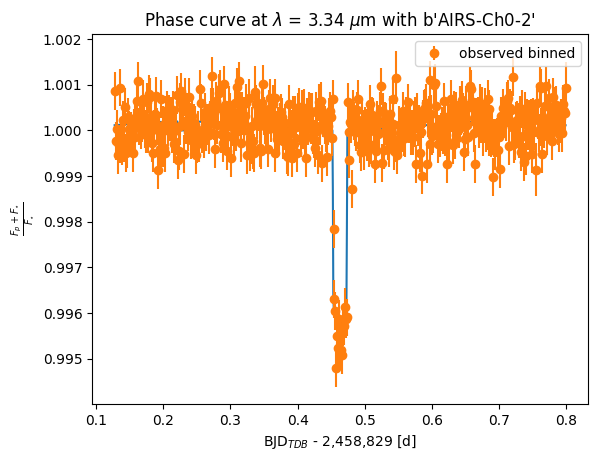

In [122]:
### PARAMETERS

P=df2['theta'][3]
R_star = df2['theta'][0]
M_star = df2['theta'][2]
time_transit = 0
R = df2['theta'][6]*R_star
print(R)
T_star = df2['theta'][1]
T_planet = df2['theta'][8]
print(T_planet)
lamb=3.34
uu = np.array([0.1, 0.06]) # Quadratic limb-darkening coefficients

def light_curve_model(time, R, T_planet, T_star): # light_curve_model(time, time_transit, P, R_star, M_star, R, T_star, T_planet, uu)
    star = Central(radius=R_star, mass=M_star)
    planet = Body(radius=R, time_transit=time_transit, period=P)
    m = Surface(u=uu)
    system = SurfaceSystem(star, m).add_body(planet, m)
    flux_star = planck(lamb*1e-6, jnp.mean(T_star))
    flux_planet = planck(lamb*1e-6, jnp.mean(T_planet))
    pc = light_curve(system, flux_planet, flux_star)(time)[:,1] + light_curve(system, flux_planet, flux_star)(time)[:,0]
    #pc = pc/np.max(pc)
    return pc

plt.figure()
plt.plot(time, light_curve_model(time, R, T_planet, T_star))
plt.errorbar(binned[0], binned[1], yerr=binned[2], fmt='o', label='observed binned')
plt.title(rf'Phase curve at $\lambda$ = {lamb} $\mu$m with {str(instru)}')
plt.legend()
plt.xlabel(r'BJD$_{TDB}$ - 2,458,829 [d]')
plt.ylabel(r'$\frac{F_p + F_{\star}}{F_{\star}}$')
plt.show()

In [123]:
def model(t, yerr, y=None):
    # Priors for the parameters we're fitting for

    """# The time of reference transit
    t0 = numpyro.sample("t0", numpyro.distributions.Normal(time_transit, 1))

    # The period
    logP = numpyro.sample("logP", numpyro.distributions.Normal(jnp.log(P), 0.1))
    period = numpyro.deterministic("period", jnp.exp(logP))"""

    # The radius of the planet
    #logR = numpyro.sample("logR_planet", numpyro.distributions.Normal(jnp.log(R), 1))
    #r = numpyro.deterministic("r", jnp.exp(logR))
    r = numpyro.sample("r", numpyro.distributions.Normal(R, 0.01))

    """# The star mass
    logM = numpyro.sample("logM", numpyro.distributions.Normal(jnp.log(M_star), 0.1))
    M = numpyro.deterministic("M", jnp.exp(logM))"""

    # The star temperature
    T_star_prior = numpyro.sample("T_star", numpyro.distributions.Normal(T_star, 10))

    # The planet temperature
    T_planet_prior = numpyro.sample("T_planet", numpyro.distributions.Normal(T_planet, 200))

    """# The limb darkening coefficients
    u_prior = numpyro.sample("u", numpyro_ext.distributions.QuadLDParams())"""

    # The orbit and light curve
    y_pred = light_curve_model(time, r, T_planet_prior, T_star_prior)

    # Let's track the light curve
    numpyro.deterministic("light_curve", y_pred)

    # The likelihood function assuming Gaussian uncertainty
    numpyro.sample("obs", numpyro.distributions.Normal(y_pred, yerr), obs=y)


In [124]:
jnp.log(0.1)

Array(-2.30258509, dtype=float64, weak_type=True)

In [125]:
import arviz as az

n_prior_samples = 3000
prior_samples = numpyro.infer.Predictive(model, num_samples=n_prior_samples)(
    jax.random.PRNGKey(0), time, yerr
)

# Let's make it into an arviz InferenceData object.
# To do so we'll first need to reshape the samples to be of shape (chains, draws, *shape)
converted_prior_samples = {
    f"{p}": np.expand_dims(prior_samples[p], axis=0) for p in prior_samples
}
prior_samples_inf_data = az.from_dict(converted_prior_samples)

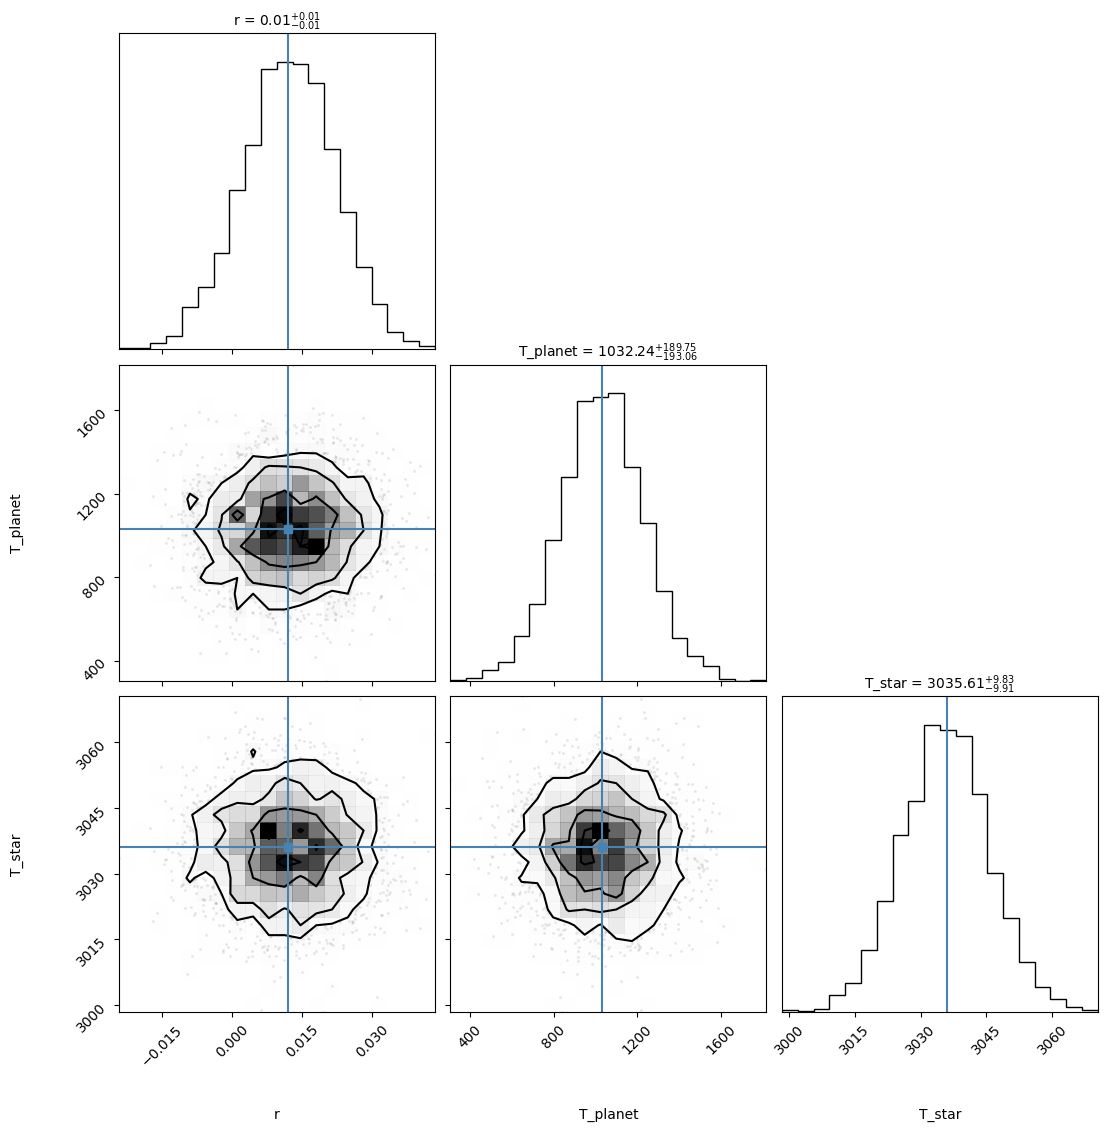

In [126]:
import corner

# Plot the corner plot
fig = plt.figure(figsize=(12, 12))
_ = corner.corner(
    prior_samples_inf_data,
    fig=fig,
    var_names=["r", "T_planet", "T_star"],
    truths=[R, T_planet, T_star],
    show_titles=True,
    title_kwargs={"fontsize": 10},
    label_kwargs={"fontsize": 10},
)


In [127]:
init_param_method = "prior_median"  # "prior_median" or "true_values"

if init_param_method == "prior_median":
    print("Starting from the prior medians")
    run_optim = numpyro_ext.optim.optimize(
        model, init_strategy=numpyro.infer.init_to_median()
    )
elif init_param_method == "true_values":
    print("Starting from the true values")
    init_params = {
        #"t0": float(time_transit),
        #"logP": jnp.log(P),
        "r": R,
        #"logM": jnp.log(M_star),
        "T_star" : float(T_star),
        "T_planet" : float(T_planet),
        #"u": uu,
    }
    run_optim = numpyro_ext.optim.optimize(
        model,
        init_strategy=numpyro.infer.init_to_value(values=init_params),
    )

time = jnp.asarray(time, dtype=jnp.float64)
yerr = jnp.asarray(yerr, dtype=jnp.float64)
observed = jnp.asarray(observed, dtype=jnp.float64)

opt_params = run_optim(jax.random.PRNGKey(3), time, yerr, y=observed)
print(opt_params)

Starting from the prior medians
{'r': Array(0.01233905, dtype=float64), 'T_star': Array(3046.3170334, dtype=float64), 'T_planet': Array(975.91757925, dtype=float64), 'light_curve': Array([1.0000944 , 1.00009516, 1.00009592, 1.00009667, 1.00009743,
       1.00009818, 1.00009893, 1.00009968, 1.00010043, 1.00010118,
       1.00010192, 1.00010266, 1.0001034 , 1.00010414, 1.00010488,
       1.00010562, 1.00010635, 1.00010708, 1.00010781, 1.00010853,
       1.00010925, 1.00010997, 1.00011069, 1.00011141, 1.00011212,
       1.00011283, 1.00011354, 1.00011424, 1.00011494, 1.00011564,
       1.00011634, 1.00011703, 1.00011772, 1.0001184 , 1.00011909,
       1.00011977, 1.00012044, 1.00012111, 1.00012178, 1.00012245,
       1.00012311, 1.00012376, 1.00012442, 1.00012507, 1.00012571,
       1.00012636, 1.00012699, 1.00012763, 1.00012826, 1.00012888,
       1.0001295 , 1.00013012, 1.00013073, 1.00013134, 1.00013194,
       1.00013254, 1.00013314, 1.00013373, 1.00013431, 1.00013489,
       1.000135

In [128]:
for k, v in opt_params.items():
    if k in ["light_curve", "obs"]:
        continue
    print(f"{k}: {v}")

r: 0.012339045849692651
T_star: 3046.3170334010388
T_planet: 975.9175792538426


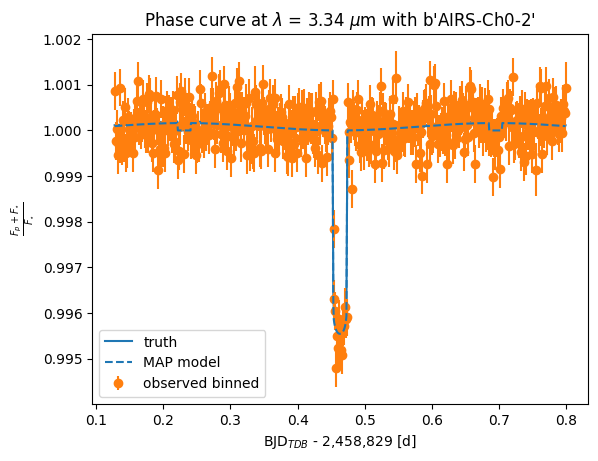

In [129]:
plt.figure()
plt.plot(time, light_curve_model(time, R, T_planet, T_star), label='truth')
plt.plot(time, opt_params["light_curve"], "--C0", label="MAP model", zorder=3)
plt.errorbar(binned[0], binned[1], yerr=binned[2], fmt='o', label='observed binned')
plt.title(rf'Phase curve at $\lambda$ = {lamb} $\mu$m with {instru}')
plt.legend()
plt.xlabel(r'BJD$_{TDB}$ - 2,458,829 [d]')
plt.ylabel(r'$\frac{F_p + F_{\star}}{F_{\star}}$')
plt.show()

In [130]:
sampler = numpyro.infer.MCMC(
    numpyro.infer.NUTS(
        model,
        dense_mass=True,
        regularize_mass_matrix=True,
        init_strategy=numpyro.infer.init_to_value(values=opt_params),
    ),
    num_warmup=500,
    num_samples=1000,
    num_chains=1,
    progress_bar=True,
)

sampler.run(jax.random.PRNGKey(1), time, yerr, y=observed)

sample: 100%|██████████| 1500/1500 [08:19<00:00,  3.00it/s, 3 steps of size 2.79e-02. acc. prob=0.83]  


In [131]:
inf_data = az.from_numpyro(sampler)
samples = sampler.get_samples()
az.summary(inf_data, var_names=["r", "T_planet", "T_star"])

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
r,0.012,0.000,0.012,0.013,0.000,0.000,865.0,791.0,NaN
T_planet,1024.780,35.238,959.958,1089.363,2.017,1.506,303.0,313.0,NaN
T_star,3037.503,8.960,3020.201,3052.543,0.526,0.323,288.0,288.0,NaN


In [150]:
print(type(inf_data))
print(sampler)
print(samples["r"])
print(jnp.std(samples["r"]))
print(np.percentile(samples["r"], [16, 50, 84], axis=0))
percentile = np.percentile(samples["r"], [16, 50, 84], axis=0)
print(percentile[1]-percentile[0])
print(percentile[2]-percentile[1])

<class 'arviz.data.inference_data.InferenceData'>
[0.01221972 0.01227436 0.01197978 0.01207637 0.01207551 0.01210351
 0.01254165 0.01256843 0.01216584 0.01224967 0.01217009 0.0124484
 0.01206708 0.01214097 0.0125927  0.01219044 0.0121791  0.01207658
 0.01211626 0.01210524 0.01217521 0.01215411 0.01213627 0.01212
 0.0122898  0.01225596 0.01224337 0.01226516 0.01228666 0.01221936
 0.01194081 0.01204484 0.01245073 0.01230872 0.01225706 0.01219811
 0.01229306 0.01228012 0.01195783 0.0120517  0.0125751  0.01251898
 0.01217004 0.01215076 0.01229589 0.01230943 0.01229536 0.01227776
 0.01211761 0.01215154 0.01241178 0.01241164 0.01232704 0.01225808
 0.01237888 0.01247904 0.01259874 0.01216162 0.0124975  0.01222297
 0.01232185 0.01221505 0.01222363 0.01223412 0.01226677 0.01234053
 0.01218118 0.01234106 0.01230252 0.01212421 0.01222682 0.01229414
 0.01225312 0.0121107  0.01220826 0.01198148 0.01233836 0.01207005
 0.01236457 0.0121075  0.01178685 0.01233376 0.0121858  0.01238191
 0.01237653 0.01

In [132]:
#There's also a method to obtain similar results to `az.summary` but directly
#as a method with the MCMC sampler. It also gives us the number of divergences.
sampler.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
  T_planet   1024.78     35.24   1025.18    971.59   1086.70    308.52      1.01
    T_star   3037.50      8.96   3037.54   3022.72   3050.83    288.71      1.00
         r      0.01      0.00      0.01      0.01      0.01    873.83      1.00

Number of divergences: 0


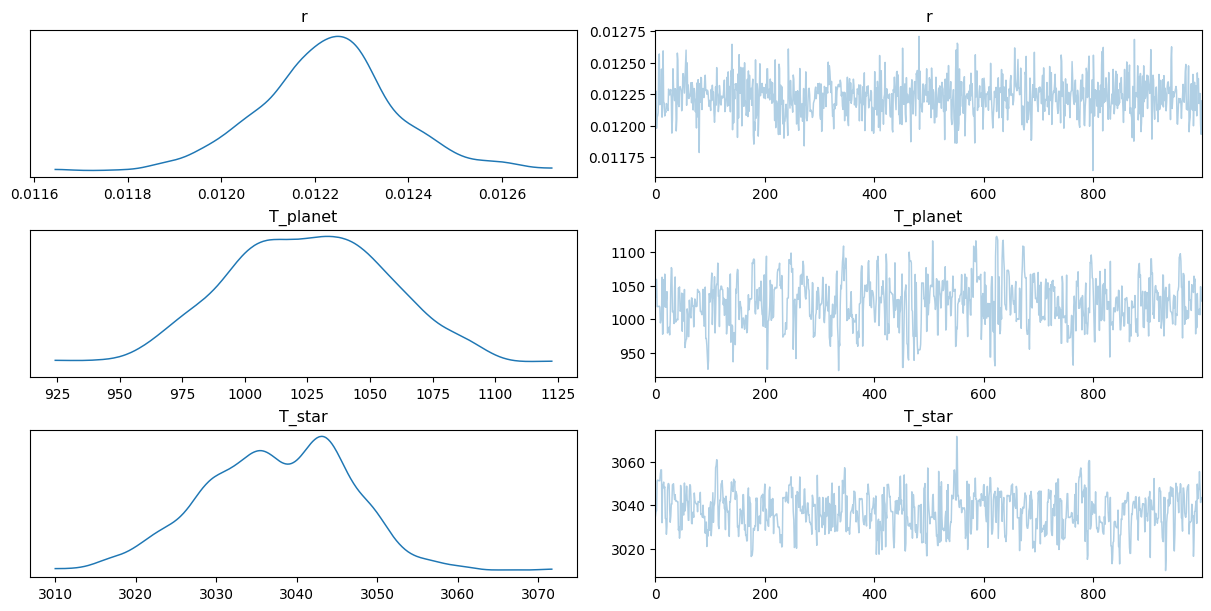

In [133]:
_ = az.plot_trace(
    inf_data,
    var_names=["r", "T_planet", "T_star"],
    backend_kwargs={"constrained_layout": True},
)

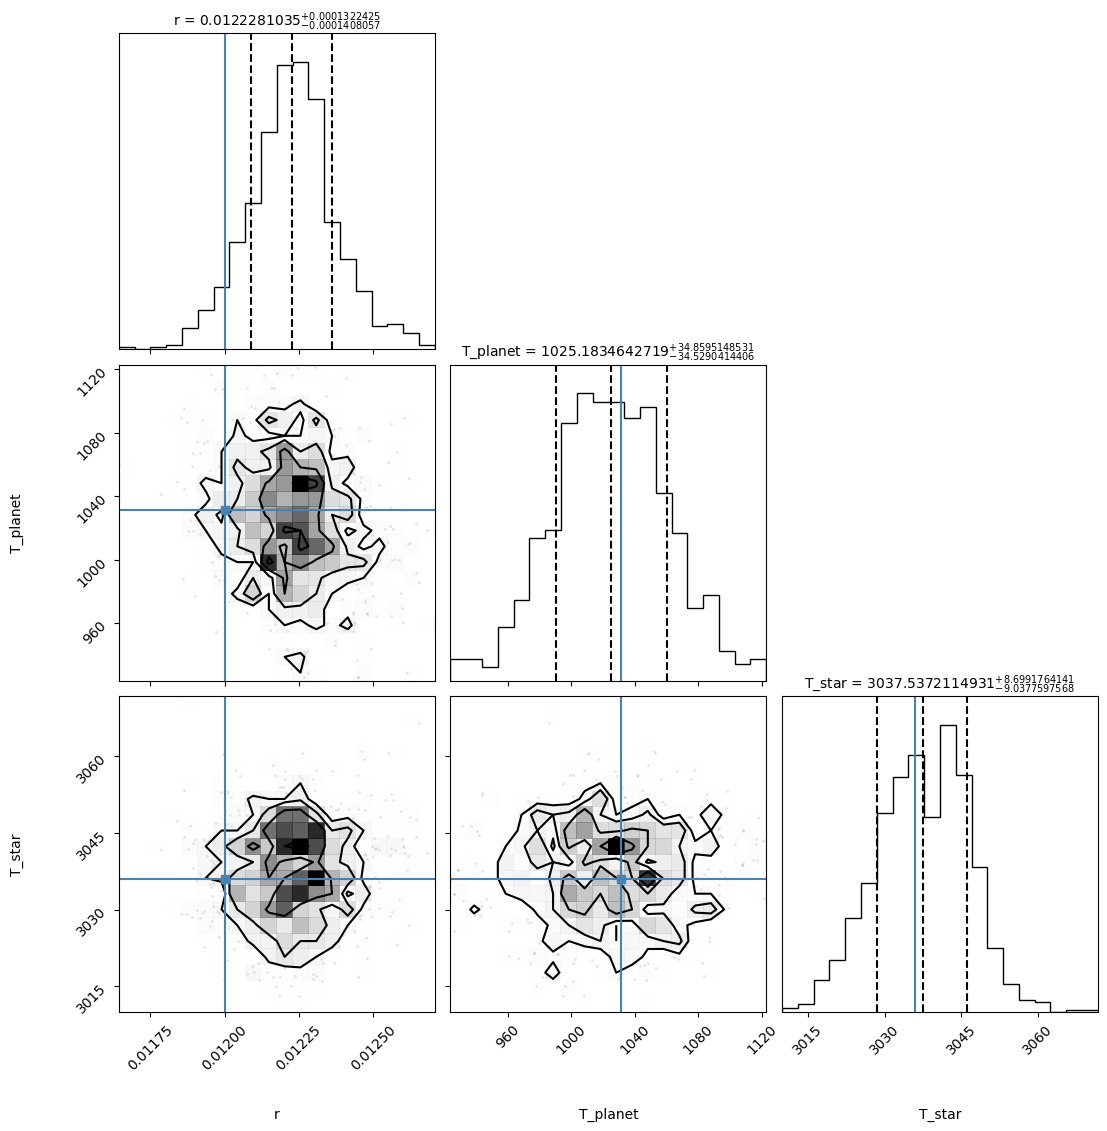

In [138]:
fig = plt.figure(figsize=(12, 12))
_ = corner.corner(
    inf_data,
    var_names=["r", "T_planet", "T_star"],
    truths=[R, T_planet, T_star],
    show_titles=True,
    quantiles=[0.16, 0.5, 0.84],
    title_kwargs={"fontsize": 10},
    label_kwargs={"fontsize": 10},
    title_fmt=".10f",
    fig=fig,
)


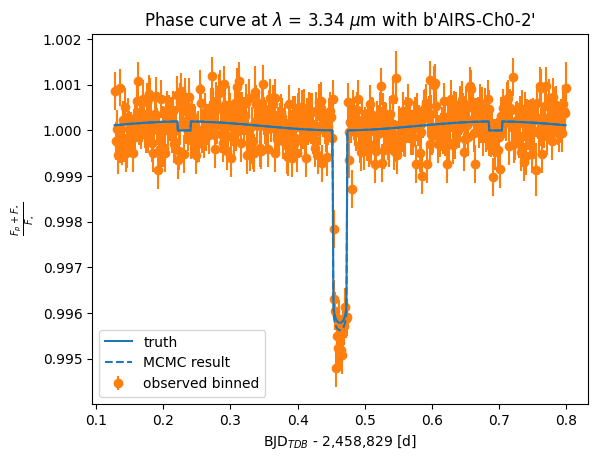

In [137]:
R_mcmc = np.median(samples["r"])
T_mcmc = np.median(samples["T_planet"])
T_star_mcmc = np.median(samples["T_star"])

plt.figure()
plt.plot(time, light_curve_model(time, R, T_planet, T_star), label='truth', zorder=3)
plt.plot(time, light_curve_model(time, R_mcmc, T_mcmc, T_star_mcmc), "--C0", label="MCMC result", zorder=3)
plt.errorbar(binned[0], binned[1], yerr=binned[2], fmt='o', label='observed binned')
plt.title(rf'Phase curve at $\lambda$ = {lamb} $\mu$m with {instru}')
plt.legend()
plt.xlabel(r'BJD$_{TDB}$ - 2,458,829 [d]')
plt.ylabel(r'$\frac{F_p + F_{\star}}{F_{\star}}$')
plt.show()